# Predict Customer churn
This notebooks is oriented at the CRISP-DM Process

## Project Planing
- Understanding Data
    - data types
    - Make plots for everything (historgrams, boxplots)
    - Missing values 
    - Correlation
- 

## Business Understanding
__Goal__:  
Predict which customer will churn the telco-company.   
Select which customer groups (which properties) have the highest chance to leave. 
- short-term customer
- bill amount (high or low)
- payment method

__Motivation__:  
If the company knows which customer will leave, it can react and adjust to hold the customer. 

__Requirements__:  
There should be at least 3 properties which indicate that a customer will quit.

__Example Anwers__:   
"This Customer will churn"  
"The following properties are non-optimal: short term contracts, senior customer, only telephone service"

## Import Packages

In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import preprocessing as prep
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

import pickle

## Import Data

In [25]:
telco_data = pd.read_csv("..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco_data.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## Data Understanding

In [26]:
print(telco_data.dtypes)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [27]:
# delete empty strings and change them to NaN
telco_data = telco_data.replace(" ", np.nan)

In [28]:
print(telco_data.isna().any())

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool


In [29]:
# change obviously wrong data types such as SeniorCitizen and TotalCharges
telco_data["SeniorCitizen"] = telco_data["SeniorCitizen"].replace(to_replace={0 : "No", 1 : "Yes"}, value=None)
telco_data["TotalCharges"] = telco_data["TotalCharges"].astype("float64")


In [30]:
# split categorical and numerical data columns
cat_features = telco_data.select_dtypes(include=['object']).columns
num_features = telco_data.select_dtypes(include=['int64', 'float64']).columns

print("categorical data", cat_features)
print("numerical data", num_features)

categorical data Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Churn'],
      dtype='object')
numerical data Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


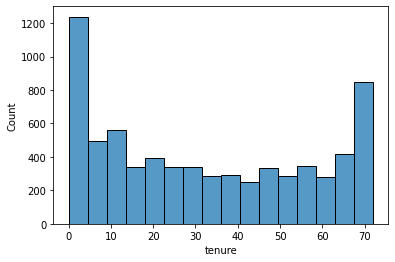

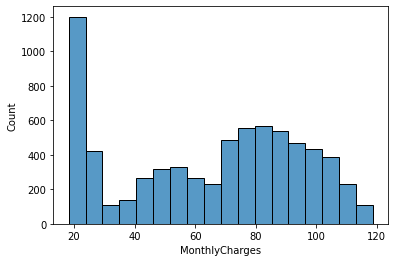

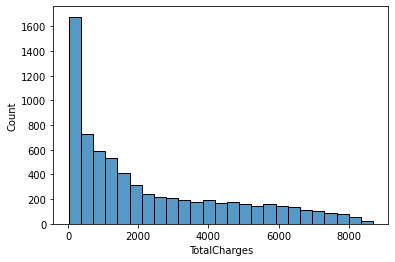

In [31]:
# show distribution of all numerical data
for c in num_features:
    sns.histplot(data=telco_data, x=c)
    plt.show()

# => None of the aspects are normal distributed, so we need to normalize them before scaling

In [32]:
# make a pivot table to compare churn rate over the numerical features
pd.pivot_table(data=telco_data, index="Churn", values=num_features)

,MonthlyCharges,TotalCharges,tenure
Churn,,,
No,61.265124,2555.344141,37.569965
Yes,74.441332,1531.796094,17.979133


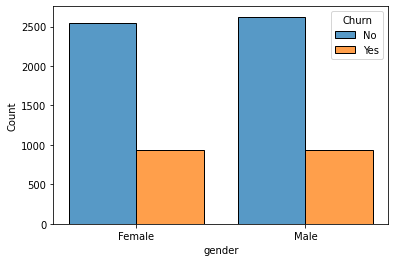

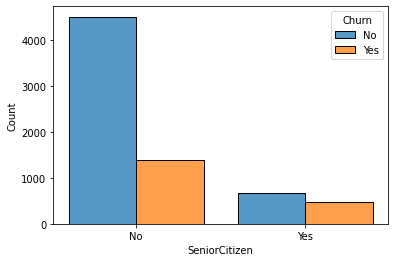

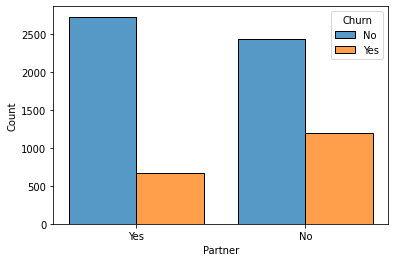

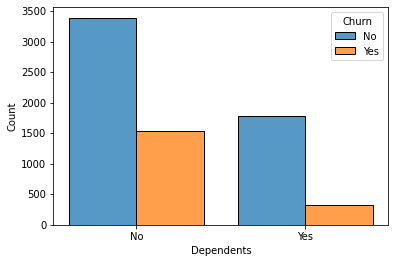

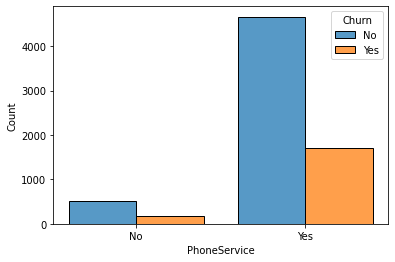

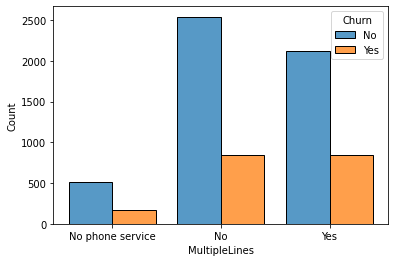

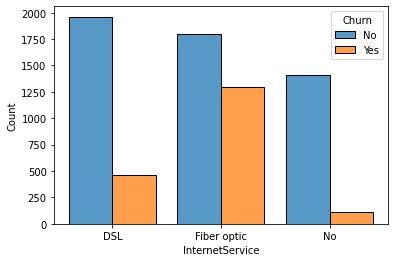

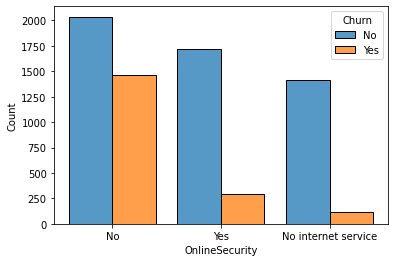

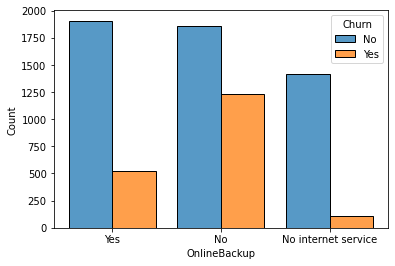

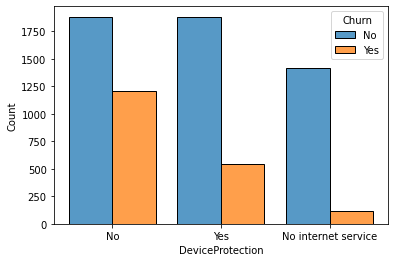

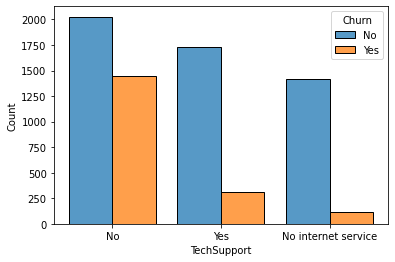

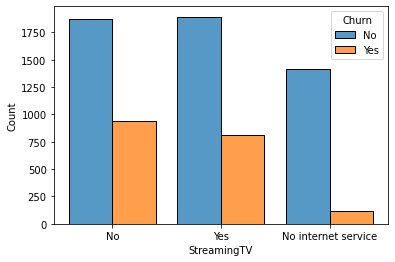

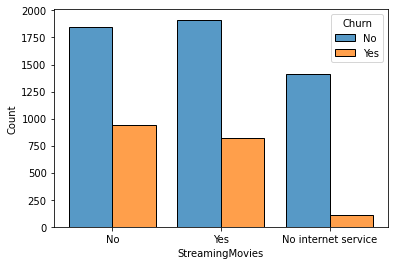

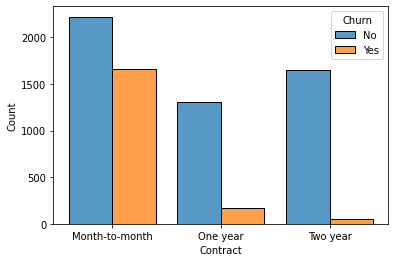

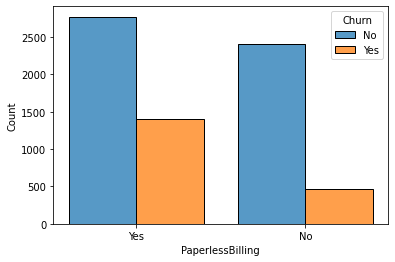

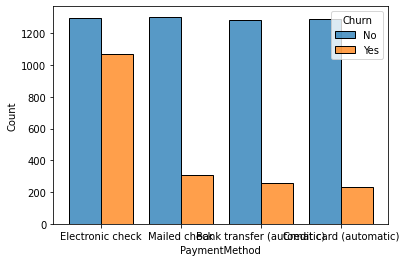

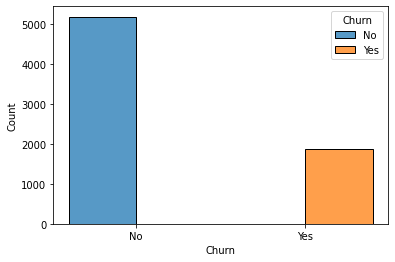

In [33]:
# relation between all categorical features (except customerID) and Churn value
for c in cat_features[1:]:
    sns.histplot(data=telco_data, x=c, hue="Churn", multiple="dodge", shrink=.8)
    plt.show()

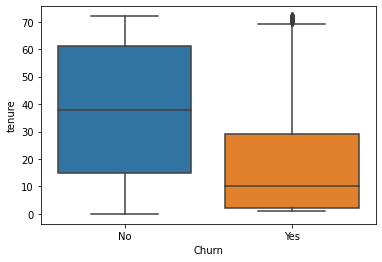

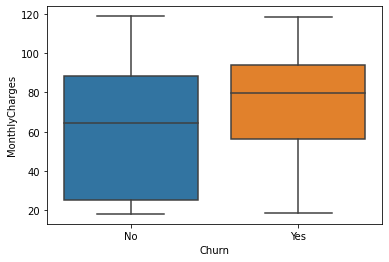

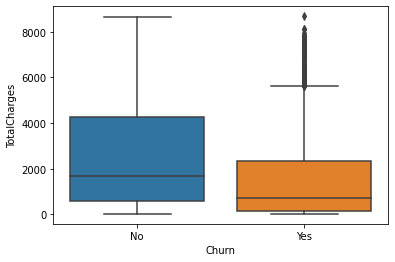

In [34]:
for c in num_features:
    sns.boxplot(data=telco_data, x="Churn", y=c)
    plt.show()

<AxesSubplot:title={'center':'Correlation between numerical properties'}>

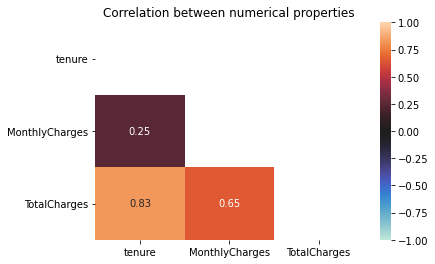

In [35]:
#plt.figure(figsize=(15, 15))
plt.title("Correlation between numerical properties")
corr = telco_data[num_features].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, mask=mask, annot=True)

## Data Preparation

In [36]:
# fill nan values
# calculate TotalCharges = tenure * MonthlyCharges

telco_data['TotalCharges'] = telco_data.apply(lambda row: row['tenure']*row['MonthlyCharges'] if np.isnan(row['TotalCharges']) else row['TotalCharges'], axis=1)

In [37]:
# make categorical data numeric

# use label encoding for binary values
binary_columns = ["PaperlessBilling", "gender",	"SeniorCitizen","Partner","Dependents", "PhoneService", "Churn"]
num_data = telco_data.drop(columns="customerID")

le = prep.LabelEncoder()
for bc in binary_columns:
    num_data[bc] = le.fit_transform(num_data[bc])

# use one-hot encoding for every other column
num_data = pd.get_dummies(num_data)

num_data.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2279.734304,0.265370,...,0.395428,0.216669,0.387903,0.550192,0.209144,0.240664,0.219225,0.216101,0.335794,0.228880
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2266.794470,0.441561,...,0.488977,0.412004,0.487307,0.497510,0.406726,0.427517,0.413751,0.411613,0.472301,0.420141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,398.550000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1394.550000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3786.600000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
# split data for training

features_data = num_data.drop(columns="Churn")
target_data = num_data["Churn"]

In [39]:
# standardize and scale

features = features_data.columns 
std = prep.StandardScaler()
X = pd.DataFrame(std.fit_transform(features_data), columns=features)

In [40]:
# transform the dataset
# Over sample the Yes rows in dataset.
oversample = SMOTE()
X,target_data = oversample.fit_resample(X, target_data)

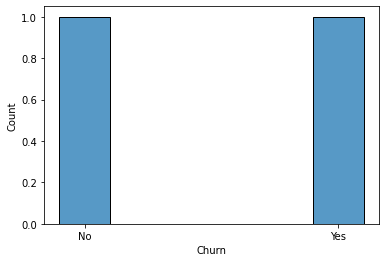

In [41]:
sns.histplot(data=target_data, x=["No", "Yes"], shrink=.2)
plt.xlabel("Churn")
plt.show()

In [42]:
# split data set in train and test set
# validation befor final evaluation will be done with cross validation
X_train, X_test, y_train, y_test = train_test_split(X,target_data,test_size=0.2,random_state=123)

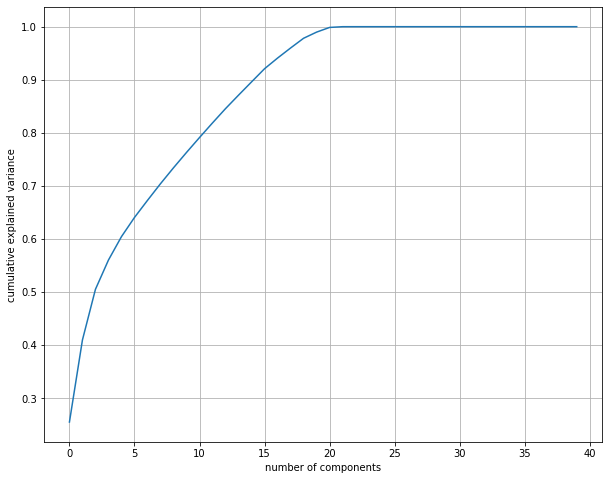

In [43]:
# plot explained variance to evaluate how many dimensions you need

pca = PCA().fit(X_train)

plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()



In [44]:
# select only 20 dimensions, as we can see, that the other 20 dimensions aren't meaningful

pca = PCA(20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [45]:
# save all data so we can load it in our prediction notebooks
pickle_out = open("..\data\X_train.p", "wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("..\data\y_train.p", "wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("..\data\X_test.p", "wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("..\data\y_test.p", "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()